In [1]:
# Imports - Generic
import numpy as np
import sys
from numpy.lib.recfunctions import append_fields
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sys

# Imports - Specialized
from Corrfunc.theory.wp import wp
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.utils import convert_rp_pi_counts_to_wp
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

#sys.path.insert(0, "/Users/chris/Documents/ProjectSigma/GalaxyTools")
#from formatting import *
#pltSetup(plt)
from GetClustering import getSDSSClustering
from GenerateHMSMMpeak import VPEAKSM_Generator
from AversaXMSM import AversaXMSM

from HM2SM import halo_mass_to_stellar_mass

# Constants
data_path = "/Users/chris/data/"

calibrate_on_centrals_only = True
catalog_centrals_only = True

z = 0.1

# File name templates
clustering_centrals_SDSS_template = "Centrals_Mass_{}-{}.csv"
clustering_centrals_RAND_template = "Random_Centrals_Mass_{}-{}.txt"
clustering_all_SDSS_template = "data_mass_{}-{}.csv"
clustering_rnd_SDSS_template = "Random_data_mass_{}-{}.csv"

In [2]:
# Read in XMF for calbration
cat = np.load("/media/uluk/Seagate Expansion Drive/Mpeak_New_1_8_MD_0.093_cut.npy")
if calibrate_on_centrals_only==True:  #Select Central Galaxies only from Dark matter Catalogue
    centrals_flag = cat['upid'] == -1
    cat = cat[centrals_flag]
Mpeak = cat['Mpeak']/cosmo.h # log10 Msun  #Mpeak in units of Mpc
bins, step = np.linspace(10.5, 15, 50, retstep=True)
bincentres = bins[:-1]+step/2

hist = np.histogram(np.log10(Mpeak), bins)[0]
phi = hist/(step * (500/cosmo.h)**3)

a = 1./(1.+z) # Constants for Behroozi et al. (2013) Appendix G, eqs. G6, G7 and G8 subhalos correction
C = np.power(10., -1.5 + 11.68*a - 28.88*a**2 + 29.33*a**3 - 10.56*a**4) #np.power(10., -2.415 + 11.68*a - 28.88*a**2 + 29.33*a**3 - 10.56*a**4)
logMcutoff =  10.94 + 8.34*a - 0.36*a**2 - 5.08*a**3 + 0.75*a**4
correction = phi * C * (logMcutoff - bincentres)
phi = np.log10(phi + correction)
 
MpeakFn = np.column_stack( (bincentres, phi) )

#This is to generate a stellar mass function for dark matter catalogue 


In [3]:
#Get Stellar Mass Function Dark matter catalogue
def get_SMF(centrals = True):
    # Get SMF - Lorenzo's code
    df1 = pd.read_csv('/home/uluk/Downloads/New_Catalog_SDSS_complete.dat', delim_whitespace=True)
    df1 = df1.query('Vmaxwt>0')

    if centrals==True:
        mass = df1.query('NewLCentSat==1')['MsMendSerExp']
        vmax=df1.query('NewLCentSat==1')['Vmaxwt']
    else:
        mass = df1['MsMendSerExp']
        vmax = df1['Vmaxwt']

    skycov=8000.
    fracper1 = len(df1)/670722
    fracsky1=(skycov*fracper1)/(4*np.pi*(180./np.pi)**2.)
    SMF_BinWidth = 0.1
    SMF_Bins = np.arange(9, 12.5, SMF_BinWidth)
    length=len(SMF_Bins)

    if centrals==True:
        SMF = np.histogram(df1.query('NewLCentSat==1')['MsMendSerExp'], weights=df1.query('NewLCentSat==1')['Vmaxwt'], bins=SMF_Bins)[0]/fracsky1/SMF_BinWidth
        print("CENTRALS")
    else:
        SMF = np.histogram(df1['MsMendSerExp'], weights=df1['Vmaxwt'], bins=SMF_Bins)[0]/fracsky1/SMF_BinWidth

    return SMF_Bins[:-1]+SMF_BinWidth/2, np.log10(SMF) 
        
bins, SMF = get_SMF(centrals=True)
    
SMFn = np.column_stack((bins, SMF))

CENTRALS


In [4]:
# Do the actual thing.

def scatterfunc(mpeak, z):
    return np.ones_like(mpeak) * 0.1

obj = AversaXMSM(z = 0.1, XMF = MpeakFn, SMF = SMFn, scatterFunc=scatterfunc)

/home/uluk/Desktop/ForUluk/AversaXMSM.py:169: RuntimeWarning: divide by zero encountered in log10
  return M_smf[:-1]+0.05 , np.log10(phi_smf)
/usr/local/lib/python3.8/dist-packages/scipy-1.6.1-py3.8-linux-x86_64.egg/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


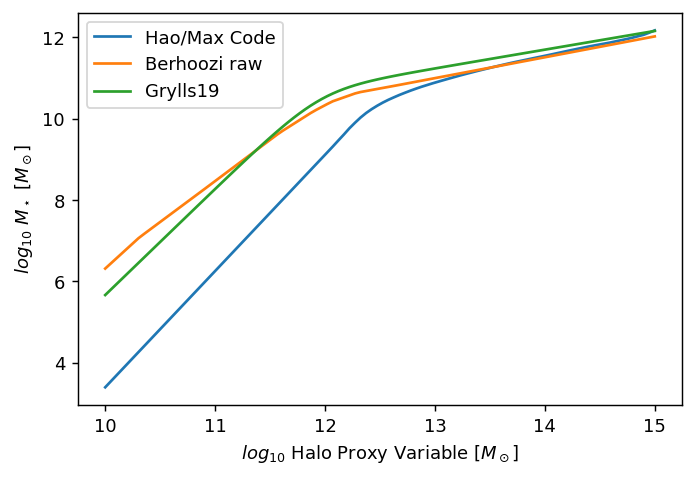

In [5]:
def berHMSM(HM, scatter = True, mag = 0.1):
    
    Ber = np.array([[9.964028776978417, 6.228474997779552],
                    [10.30935251798561, 7.079616306954434],
                    [10.905035971223022, 8.275921485034193],
                    [11.58705035971223, 9.657234212629893],
                    [11.889208633093524, 10.175131006306064],
                    [12.06187050359712, 10.421689315214492],
                    [12.294964028776977, 10.64343192112976],
                    [12.666187050359712, 10.827853272937203],
                    [15.13525179856115, 12.094377831068474]])

    
    mhalo = Ber[:, 0]
    mstar = Ber[:, 1]
    HMSM = interp1d(mhalo, mstar, bounds_error=False, fill_value="extrapolate")
    res = HMSM(HM)
    
    if scatter:
        res += np.random.normal(scale=mag, size=np.shape(res))
    
    return res



mhalo = np.linspace(10, 15, 100)

fig, ax = plt.subplots(dpi=130)


plt.plot(mhalo, obj.X2SM(mhalo, scatter = False), label = "Hao/Max Code")
plt.plot(mhalo, berHMSM(mhalo, scatter=False), label="Berhoozi raw")
plt.plot(mhalo, halo_mass_to_stellar_mass(mhalo, 0.1, formula = "Grylls19", scatter=0), label="Grylls19")
plt.xlabel("$log_{10}$ Halo Proxy Variable $[M_\odot]$")
plt.ylabel("$log_{10}$ $M_\star$ $[M_\odot]$")
plt.legend()
plt.show()


        

## Simulated Catalog

In [6]:
boxsize = 500 # Mpc/h
z = 0.1
cut = 500 # Mpc/h

# Load catalog
catalog = np.load("/media/uluk/Seagate Expansion Drive/Mpeak_New_1_8_MD_0.093_cut.npy")

print(catalog.dtype)

# Cut down volume for faster testing, if we need to.
cut_flag = (catalog['x'] < cut) & (catalog['y'] < cut) & (catalog['z'] < cut)
catalog = catalog[cut_flag]

# Filter out only centrals
if catalog_centrals_only==True:
    centrals_flag = catalog['upid'] == -1
    catalog = catalog[centrals_flag]

# HM2SM 
mstar = obj.X2SM(np.log10(catalog['Mpeak']/cosmo.h), scatter=True)
mstar_Ber = berHMSM(np.log10(catalog['Mpeak']/cosmo.h), scatter = True)
mstar_Ber2 = berHMSM(np.log10(catalog['Mpeak']/cosmo.h), scatter = True, mag = 0.2)

[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('id', '<i8'), ('upid', '<i8'), ('mvir', '<f4'), ('First_Acc_Scale', '<f4'), ('First_Acc_Mvir', '<f4'), ('Mpeak', '<f4'), ('Mpeak_Scale', '<f4')]


0.13793103448275862
CENTRALS


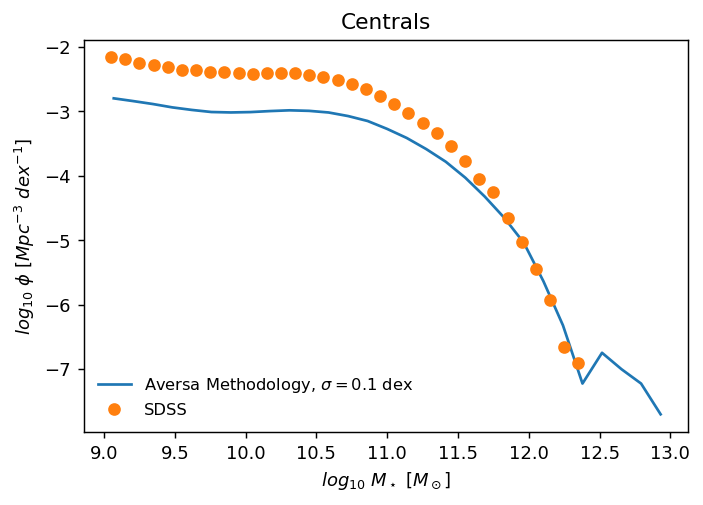

In [7]:

# Plot SMF
smf_bins, step = np.linspace(9, 13, 30, retstep=True)

fig, ax = plt.subplots(dpi = 130)
#niceplot(ax)


print(step)
hist = np.histogram(mstar, smf_bins)[0]
plt.plot(smf_bins[:-1]+step/2, np.log10(hist/(step*(cut/0.7)**3)), label = "Aversa Methodology, $\sigma=0.1$ dex")

hist = np.histogram(mstar_Ber, smf_bins)[0]
#plt.plot(smf_bins[:-1]+step/2, np.log10(hist/(step*(cut/0.7)**3)), label = "Berhoozi raw, $\sigma=0.1$ dex")

hist = np.histogram(mstar_Ber2, smf_bins)[0]
#plt.plot(smf_bins[:-1]+step/2, np.log10(hist/(step*(cut/0.7)**3)), label = "Berhoozi raw, $\sigma=0.2$ dex")

bins, SMF = get_SMF(catalog_centrals_only)

plt.plot(bins, SMF, 'o', label = "SDSS" )

if catalog_centrals_only==True:
    plt.title("Centrals")
else:
    plt.title("All Galaxies")


plt.xlabel("$log_{10}$ $M_\star$ $[M_\odot]$")
plt.ylabel("$log_{10}$ $\phi$ $[Mpc^{-3}$ $dex^{-1}]$")



plt.legend( fontsize = 9, frameon=False)
plt.savefig("/home/uluk/Desktop/ForUluk/SMF.png")
plt.show()

In [8]:
def Clustring(low, high):
    
    fig, ax = plt.subplots(dpi=130)
    #niceplot(ax)
    
    ####################################################
    # Cut by SM
    cut_flag = (mstar >= low) & ((mstar <= high))
    catalogSubject = catalog[cut_flag]

    # Calculate wp itself
    nbins = 30
    pimax = 20
    bins = np.linspace(-0.2, 1, nbins+1) # log10 Msun h^-1

    cor = 0.7/cosmo.h
    x = (catalogSubject['x']*cor)
    y = (catalogSubject['y']*cor)
    z = (catalogSubject['z']*cor)
    #cut = cut * cor
    #pimax *= cor
    
    results_wp = wp(cut*cor, pimax*cor, 8, 10**bins, x, y, z, verbose=True)
    
    midpoints = np.log10((10**bins[1:] + 10**bins[:-1])/2)
    
    plt.plot(midpoints, np.log10(results_wp['wp']), label = "Hao/Max Code, $\sigma=0.1$ dex")
    
    ####################################################
    # Cut by SM
    cut_flag = (mstar_Ber >= low) & ((mstar_Ber <= high))
    catalogSubject = catalog[cut_flag]

    # Calculate wp itself
    nbins = 30
    pimax = 20
    bins = np.linspace(-0.2, 1, nbins+1)
    
    cor = 0.7/cosmo.h
    x = (catalogSubject['x']*cor)
    y = (catalogSubject['y']*cor)
    z = (catalogSubject['z']*cor)

    #results_wp = wp(cut*cor , pimax*cor, 8, 10**bins, x, y, z, verbose=True)
    
    midpoints = np.log10((10**bins[1:] + 10**bins[:-1])/2)
    
    #plt.plot(midpoints, np.log10(results_wp['wp']), label = "Berhoozi raw, $\sigma=0.1$ dex")
    
    ####################################################
    # Cut by SM
    cut_flag = (mstar_Ber2 >= low) & ((mstar_Ber2 <= high))
    catalogSubject = catalog[cut_flag]

    # Calculate wp itself
    nbins = 30
    pimax = 20
    bins = np.linspace(-0.2, 1, nbins+1)
    
    cor = 0.7/cosmo.h
    x = (catalogSubject['x']*cor)
    y = (catalogSubject['y']*cor)
    z = (catalogSubject['z']*cor)

    #results_wp = wp(cut*cor , pimax*cor, 8, 10**bins, x, y, z, verbose=True)
    
    midpoints = np.log10((10**bins[1:] + 10**bins[:-1])/2)
    
    #plt.plot(midpoints, np.log10(results_wp['wp']), label = "Berhoozi raw, $\sigma=0.2$ dex")


    #######
    
    low_str = str(np.round(low, 1))
    high_str = str(np.round(high, 1))
    
    
    if catalog_centrals_only==True:
        data_str = clustering_centrals_SDSS_template
        rand_str = clustering_centrals_RAND_template
    else:
        data_str = clustering_all_SDSS_template
        rand_str = clustering_rnd_SDSS_template
        
    wp_SDSS, std_SDSS, SDSSmidpoints = getSDSSClustering(data_str.format(low_str, high_str),
        rand_str.format(low_str, high_str), Rbins = bins, centrals=catalog_centrals_only)
    
    if catalog_centrals_only:
        plt.title("Centrals")
    else:
        plt.title("All Galaxies")

    plt.errorbar(SDSSmidpoints, wp_SDSS, yerr=std_SDSS, fmt='o', label = "SDSS",)

    plt.xlabel("$log_{10}$ $r$ $[kpc/h]$")
    plt.ylabel("$w_p$")
    plt.text(np.amin(midpoints), np.amin(np.log10(results_wp['wp'])), "${} < M_\star < {}$".format(low_str, high_str))
    plt.legend(frameon=False)
    plt.savefig("/home/uluk/Desktop/ForUluk/Clus{}.png".format(high_str))
    plt.show()
    

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 51,51,25.  Time taken =   0.044 sec
Using AVX2 kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.035 secs


Attempting to read data from file
Data Found


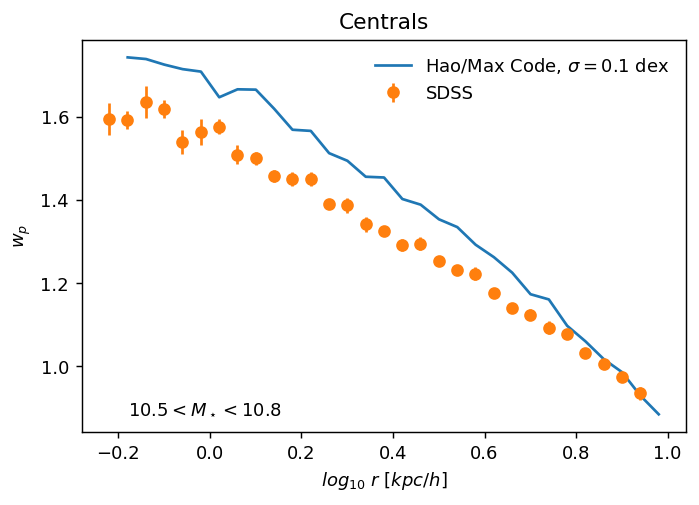

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 51,51,25.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs


Attempting to read data from file
Data Found


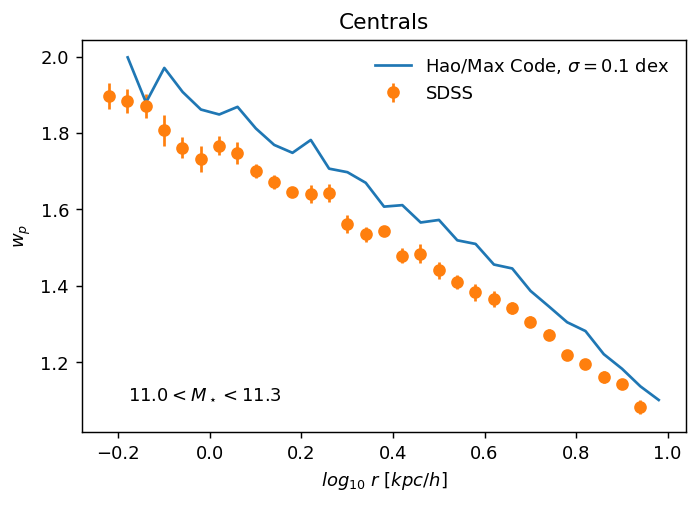

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 51,51,25.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs


Attempting to read data from file
Data Found


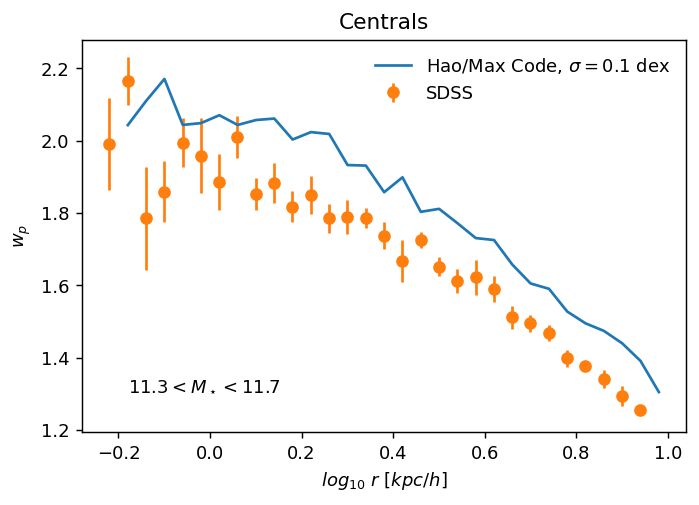

In [9]:
if catalog_centrals_only:
    Clustring(10.5, 10.8)
    Clustring(11.0, 11.3)
    Clustring(11.3, 11.7)
else:
    Clustring(10.4, 10.6)
    Clustring(11.0, 11.2)
    Clustring(11.2, 11.5)
    
    